# FlowToImg


## Imports


In [1]:
from pathlib import Path
import json
import time
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scapy.all import PcapReader, IP

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize


## Project Paths


In [2]:
# project paths
PROJECT_ROOT = Path(r"E:\Project\flow2img")
RAW_PCAP_DIR = PROJECT_ROOT / "data" / "raw" / "pcap"

# output folders
OUT_IMG_ROOT = PROJECT_ROOT / "data" / "images" / "pcap_multiclass_raw"
SPLIT_ROOT = PROJECT_ROOT / "data" / "images" / "pcap_multiclass_split"

RAW_PCAP_DIR, OUT_IMG_ROOT, SPLIT_ROOT


(WindowsPath('E:/Project/flow2img/data/raw/pcap'),
 WindowsPath('E:/Project/flow2img/data/images/pcap_multiclass_raw'),
 WindowsPath('E:/Project/flow2img/data/images/pcap_multiclass_split'))

## List PCAP Files


In [3]:
pcaps = sorted(RAW_PCAP_DIR.glob("*.pcap"))
print("found pcap files:", len(pcaps))
for p in pcaps:
    print(" -", p.name)

if not pcaps:
    raise FileNotFoundError(f"no pcap files found in {RAW_PCAP_DIR}")


found pcap files: 5
 - BenignTraffic.pcap
 - DDoS-UDP_Flood.pcap
 - DNS_Spoofing.pcap
 - DoS-HTTP_Flood.pcap
 - DoS-SYN_Flood.pcap


## Class Mapping


In [4]:
# multiclass labels based on your downloaded files
# key = pcap filename, value = class name (folder name)
pcap_classes = {
    "BenignTraffic.pcap": "benign",
    "DoS-SYN_Flood.pcap": "dos_syn_flood",
    "DDoS-UDP_Flood.pcap": "ddos_udp_flood",
    "DoS-HTTP_Flood.pcap": "dos_http_flood",
    "DNS_Spoofing.pcap": "dns_spoofing",
}

# quick existence check
for fname, cls in pcap_classes.items():
    p = RAW_PCAP_DIR / fname
    print(fname, "->", cls, "| exists:", p.exists())


BenignTraffic.pcap -> benign | exists: True
DoS-SYN_Flood.pcap -> dos_syn_flood | exists: True
DDoS-UDP_Flood.pcap -> ddos_udp_flood | exists: True
DoS-HTTP_Flood.pcap -> dos_http_flood | exists: True
DNS_Spoofing.pcap -> dns_spoofing | exists: True


## Image Encoding Helpers


In [5]:
# image generation params
TIME_WINDOW_SEC = 2.0
IMG_SIZE = 32
MAX_PKT_LEN = 1500
MIN_PKTS_PER_WINDOW = 10

def iter_packets(pcap_path: Path):
    # yield (timestamp, packet_length) only for ip packets
    with PcapReader(str(pcap_path)) as pcap:
        for pkt in pcap:
            if IP not in pkt:
                continue
            try:
                t = float(pkt.time)
                l = len(bytes(pkt))
            except Exception:
                continue
            if l <= 0:
                continue
            yield t, min(l, MAX_PKT_LEN)

def window_to_image(times: np.ndarray, lens: np.ndarray) -> np.ndarray:
    # convert one time window to a 2d histogram image
    t0 = times[0]
    dt = times - t0

    # x axis = time bins inside window
    x = np.floor((dt / TIME_WINDOW_SEC) * IMG_SIZE).astype(int)
    x = np.clip(x, 0, IMG_SIZE - 1)

    # y axis = packet length bins
    y = np.floor((lens / MAX_PKT_LEN) * IMG_SIZE).astype(int)
    y = np.clip(y, 0, IMG_SIZE - 1)

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    for xi, yi in zip(x, y):
        img[IMG_SIZE - 1 - yi, xi] += 1.0

    # log + normalize (better contrast)
    img = np.log1p(img)
    if img.max() > 0:
        img = img / img.max()

    return (img * 255).astype(np.uint8)


## Generate Images per Class


In [6]:
MAX_IMAGES_PER_PCAP = 100

OUT_IMG_ROOT.mkdir(parents=True, exist_ok=True)

def pcap_to_class_images(pcap_path: Path, class_name: str, max_images: int):
    out_dir = OUT_IMG_ROOT / class_name
    out_dir.mkdir(parents=True, exist_ok=True)

    buf_t, buf_l = [], []
    win_start = None
    saved = 0

    for t, l in iter_packets(pcap_path):
        if win_start is None:
            win_start = t

        if t - win_start < TIME_WINDOW_SEC:
            buf_t.append(t)
            buf_l.append(l)
            continue

        if len(buf_t) >= MIN_PKTS_PER_WINDOW:
            img = window_to_image(np.array(buf_t), np.array(buf_l))
            Image.fromarray(img, mode="L").save(out_dir / f"{class_name}_{saved:06d}.png")
            saved += 1
            if saved >= max_images:
                break

        buf_t, buf_l = [t], [l]
        win_start = t

    print("class:", class_name, "| saved:", saved, "| folder:", out_dir)

for fname, cls in pcap_classes.items():
    p = RAW_PCAP_DIR / fname
    if not p.exists():
        print("missing:", fname, "(skip)")
        continue
    pcap_to_class_images(p, cls, MAX_IMAGES_PER_PCAP)


class: benign | saved: 100 | folder: E:\Project\flow2img\data\images\pcap_multiclass_raw\benign
class: dos_syn_flood | saved: 100 | folder: E:\Project\flow2img\data\images\pcap_multiclass_raw\dos_syn_flood
class: ddos_udp_flood | saved: 100 | folder: E:\Project\flow2img\data\images\pcap_multiclass_raw\ddos_udp_flood
class: dos_http_flood | saved: 100 | folder: E:\Project\flow2img\data\images\pcap_multiclass_raw\dos_http_flood
class: dns_spoofing | saved: 100 | folder: E:\Project\flow2img\data\images\pcap_multiclass_raw\dns_spoofing


## Visualize Samples


class folders: ['benign', 'ddos_udp_flood', 'dns_spoofing', 'dos_http_flood', 'dos_syn_flood']


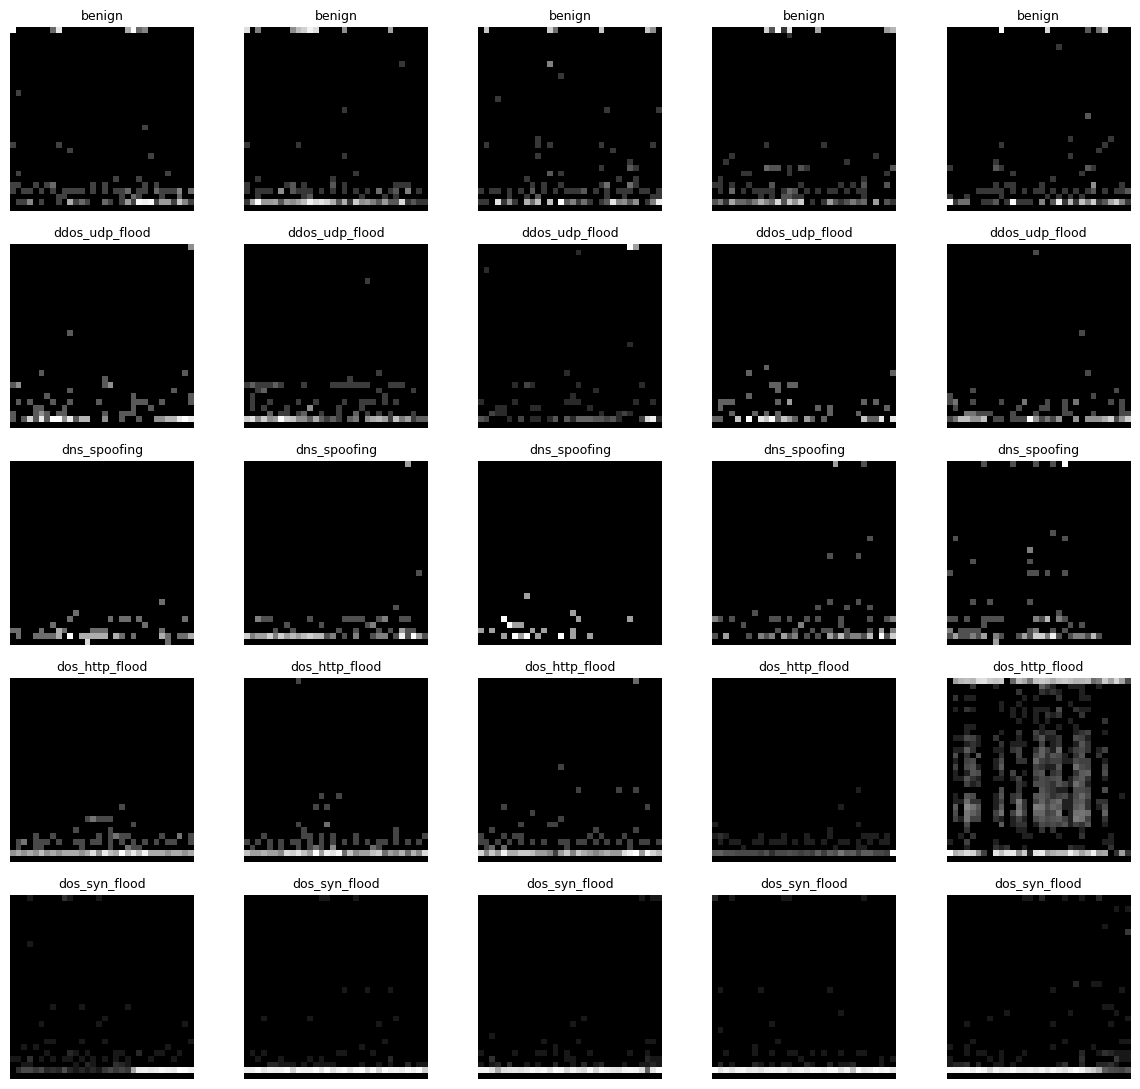

In [7]:
# show a few images per class
classes = sorted((OUT_IMG_ROOT).glob("*"))
print("class folders:", [c.name for c in classes])

fig, axes = plt.subplots(len(classes), 5, figsize=(12, 2.2 * len(classes)))

for i, cdir in enumerate(classes):
    imgs = sorted(cdir.glob("*.png"))[:5]
    for j in range(5):
        ax = axes[i, j] if len(classes) > 1 else axes[j]
        if j < len(imgs):
            im = Image.open(imgs[j])
            ax.imshow(im, cmap="gray")
            ax.set_title(cdir.name, fontsize=9)
        ax.axis("off")

plt.tight_layout()
plt.show()


## Train/Val/Test Split


In [8]:
# multiclass split: train/val/test inside each class folder
SEED = 42
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

random.seed(SEED)

def split_and_copy_class(class_dir: Path, class_name: str):
    files = sorted(class_dir.glob("*.png"))
    random.shuffle(files)

    n = len(files)
    n_train = int(TRAIN_RATIO * n)
    n_val = int(VAL_RATIO * n)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    def copy_to(files_list, split_name):
        dst = SPLIT_ROOT / split_name / class_name
        dst.mkdir(parents=True, exist_ok=True)
        for f in files_list:
            shutil.copy2(f, dst / f.name)

    copy_to(train_files, "train")
    copy_to(val_files, "val")
    copy_to(test_files, "test")

    return len(train_files), len(val_files), len(test_files)

# clear old split folder (optional)
# if SPLIT_ROOT.exists():
#     shutil.rmtree(SPLIT_ROOT)

SPLIT_ROOT.mkdir(parents=True, exist_ok=True)

stats = {}
for cdir in sorted(OUT_IMG_ROOT.glob("*")):
    tr, va, te = split_and_copy_class(cdir, cdir.name)
    stats[cdir.name] = (tr, va, te)

stats


{'benign': (70, 15, 15),
 'ddos_udp_flood': (70, 15, 15),
 'dns_spoofing': (70, 15, 15),
 'dos_http_flood': (70, 15, 15),
 'dos_syn_flood': (70, 15, 15)}

## Split Summary


In [9]:
for cls, (tr, va, te) in stats.items():
    print(cls, "train/val/test =", tr, va, te)

print("\nexample train folders:")
for p in sorted((SPLIT_ROOT / "train").glob("*")):
    print(" -", p.name, "| images:", len(list(p.glob("*.png"))))


benign train/val/test = 70 15 15
ddos_udp_flood train/val/test = 70 15 15
dns_spoofing train/val/test = 70 15 15
dos_http_flood train/val/test = 70 15 15
dos_syn_flood train/val/test = 70 15 15

example train folders:
 - benign | images: 70
 - ddos_udp_flood | images: 70
 - dns_spoofing | images: 70
 - dos_http_flood | images: 70
 - dos_syn_flood | images: 70


## Training Configuration


In [10]:
# project paths
PROJECT_ROOT = Path(r"E:\Project\flow2img")

# this is where you already created the multiclass split
# structure:
# pcap_multiclass_split/
#   train/<class>/*.png
#   val/<class>/*.png
#   test/<class>/*.png
SPLIT_ROOT = PROJECT_ROOT / "data" / "images" / "pcap_multiclass_split"

train_dir = SPLIT_ROOT / "train"
val_dir   = SPLIT_ROOT / "val"
test_dir  = SPLIT_ROOT / "test"

# save folder
SAVE_DIR = PROJECT_ROOT / "runs" / "resnet18_multiclass"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = SAVE_DIR / "model_state.pt"
META_PATH  = SAVE_DIR / "meta.json"

# training params
SEED = 42
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-4
NUM_WORKERS = 2

# set seed for reproducibility (basic)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


## Transforms and DataLoaders


In [11]:
# resnet expects 3-channel input and usually 224x224
# our images are grayscale 32x32, so we:
# - convert grayscale to 3 channels
# - resize to 224x224
# - normalize like imagenet

train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir, transform=eval_tf)
test_ds  = datasets.ImageFolder(test_dir, transform=eval_tf)

print("classes:", train_ds.classes)
print("train size:", len(train_ds), "val size:", len(val_ds), "test size:", len(test_ds))

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

num_classes = len(train_ds.classes)


classes: ['benign', 'ddos_udp_flood', 'dns_spoofing', 'dos_http_flood', 'dos_syn_flood']
train size: 350 val size: 75 test size: 75


## Model Setup


In [12]:
# load pretrained resnet18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# replace final layer for multiclass
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("model ready | num_classes:", num_classes)


model ready | num_classes: 5


## Epoch Runner


In [13]:
def run_epoch(model, loader, criterion, optimizer=None):
    # if optimizer is none -> eval mode
    train = optimizer is not None
    model.train() if train else model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, f1


## Training Loop


In [14]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
}

best_val_f1 = -1.0
best_state = None

t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, criterion, optimizer=optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader, criterion, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(va_f1)

    print(f"epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    # save best model based on val macro-f1
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        torch.save(best_state, MODEL_PATH)

        meta = {
            "model": "resnet18",
            "num_classes": num_classes,
            "classes": train_ds.classes,
            "image_size": [224, 224],
            "best_val_f1": float(best_val_f1),
            "epochs_trained": epoch,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "seed": SEED,
        }
        META_PATH.write_text(json.dumps(meta, indent=2))

t1 = time.time()
print("done. best val macro-f1:", best_val_f1)
print("saved model:", MODEL_PATH)
print("saved meta:", META_PATH)
print("training time (sec):", round(t1 - t0, 2))


epoch 01 | train loss 0.7196 acc 0.743 f1 0.743 | val loss 1.0591 acc 0.587 f1 0.542
epoch 02 | train loss 0.2556 acc 0.909 f1 0.908 | val loss 0.5936 acc 0.787 f1 0.782
epoch 03 | train loss 0.1624 acc 0.943 f1 0.943 | val loss 0.3948 acc 0.867 f1 0.864
epoch 04 | train loss 0.0831 acc 0.986 f1 0.986 | val loss 0.4381 acc 0.893 f1 0.895
epoch 05 | train loss 0.0527 acc 0.994 f1 0.994 | val loss 0.2393 acc 0.893 f1 0.894
epoch 06 | train loss 0.0535 acc 0.980 f1 0.980 | val loss 0.3114 acc 0.880 f1 0.880
epoch 07 | train loss 0.0245 acc 0.994 f1 0.994 | val loss 0.4899 acc 0.853 f1 0.848
epoch 08 | train loss 0.0210 acc 0.997 f1 0.997 | val loss 0.2606 acc 0.867 f1 0.864
epoch 09 | train loss 0.0172 acc 1.000 f1 1.000 | val loss 0.2667 acc 0.880 f1 0.878
epoch 10 | train loss 0.0088 acc 1.000 f1 1.000 | val loss 0.2829 acc 0.920 f1 0.920
epoch 11 | train loss 0.0069 acc 1.000 f1 1.000 | val loss 0.2477 acc 0.880 f1 0.881
epoch 12 | train loss 0.0057 acc 1.000 f1 1.000 | val loss 0.2050

## Learning Curves


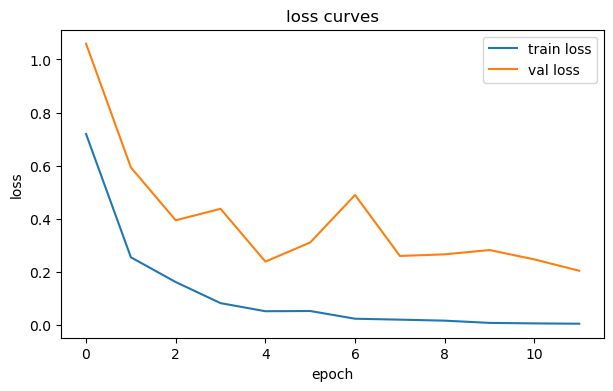

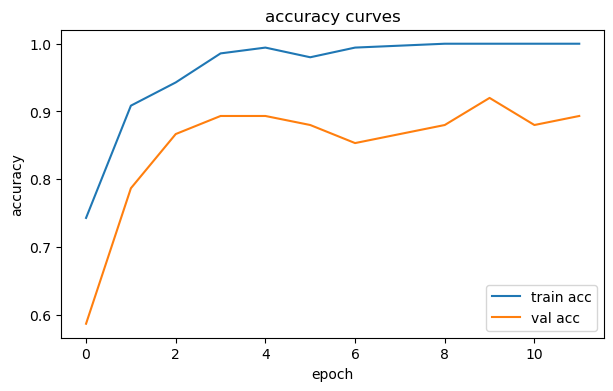

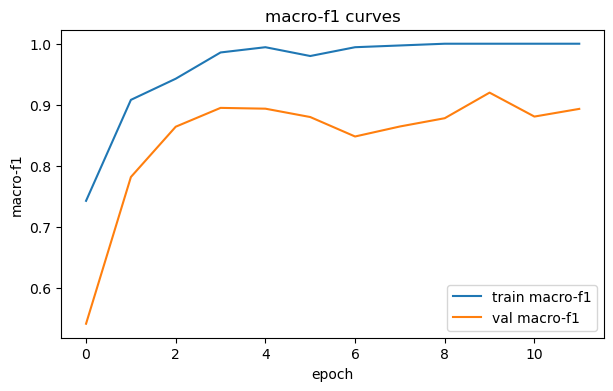

In [15]:
# loss curves
plt.figure(figsize=(7, 4))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss curves")
plt.legend()
plt.show()

# accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy curves")
plt.legend()
plt.show()

# macro-f1 curves
plt.figure(figsize=(7, 4))
plt.plot(history["train_f1"], label="train macro-f1")
plt.plot(history["val_f1"], label="val macro-f1")
plt.xlabel("epoch")
plt.ylabel("macro-f1")
plt.title("macro-f1 curves")
plt.legend()
plt.show()


## Load Best Checkpoint


In [16]:
# load meta info
meta = json.loads(META_PATH.read_text())
print("loaded meta:", meta)

# load weights
state = torch.load(MODEL_PATH, map_location="cpu")
model.load_state_dict(state)
model = model.to(device)
model.eval()

print("model loaded and ready for evaluation/prediction.")


loaded meta: {'model': 'resnet18', 'num_classes': 5, 'classes': ['benign', 'ddos_udp_flood', 'dns_spoofing', 'dos_http_flood', 'dos_syn_flood'], 'image_size': [224, 224], 'best_val_f1': 0.9199220134704007, 'epochs_trained': 10, 'batch_size': 32, 'lr': 0.0001, 'seed': 42}


C:\Users\iczme\AppData\Local\Temp\ipykernel_22456\1291865652.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location="cpu")


model loaded and ready for evaluation/prediction.


## Test Evaluation


 TEST METRICS 
Test loss : 0.2599
Test accuracy : 0.9333
Precision (micro/macro/weighted): 0.9333 / 0.9412 / 0.9412
Recall    (micro/macro/weighted): 0.9333 / 0.9333 / 0.9333
F1-score  (micro/macro/weighted): 0.9333 / 0.9325 / 0.9325

 CLASSIFICATION REPORT (TEST) 
                precision    recall  f1-score   support

        benign       1.00      0.93      0.97        15
ddos_udp_flood       0.92      0.73      0.81        15
  dns_spoofing       1.00      1.00      1.00        15
dos_http_flood       1.00      1.00      1.00        15
 dos_syn_flood       0.79      1.00      0.88        15

      accuracy                           0.93        75
     macro avg       0.94      0.93      0.93        75
  weighted avg       0.94      0.93      0.93        75



<Figure size 700x700 with 0 Axes>

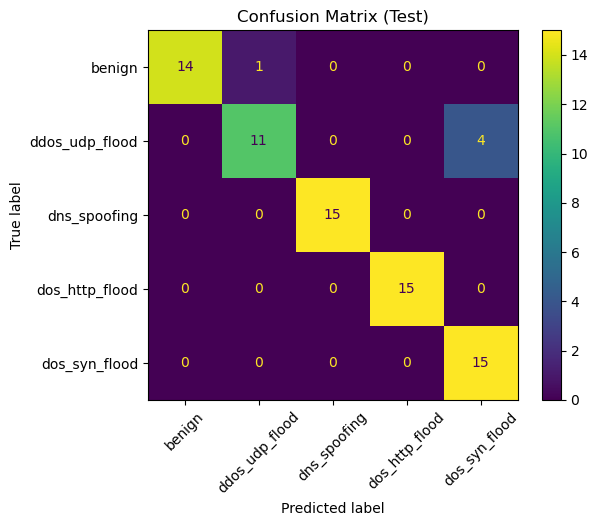


 ROC-AUC (OvR, multiclass) 
ROC-AUC macro   : 0.9911
ROC-AUC weighted: 0.9911


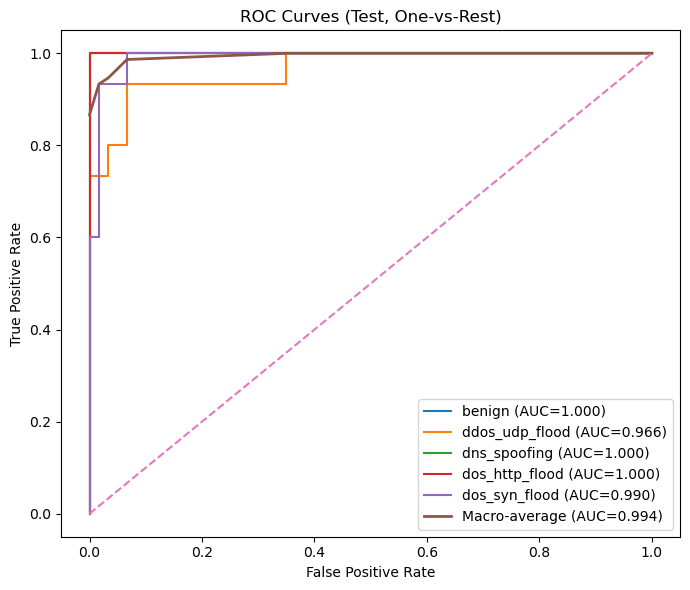

In [17]:
all_preds = []
all_labels = []
all_probs = []

running_loss = 0.0
n_samples = 0

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_dev = y.to(device)

        logits = model(x)
        loss = criterion(logits, y_dev)

        # accumulate loss
        bs = x.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

# core metrics
test_loss = running_loss / max(1, n_samples)
test_acc  = accuracy_score(all_labels, all_preds)

prec_micro = precision_score(all_labels, all_preds, average="micro", zero_division=0)
prec_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
prec_w     = precision_score(all_labels, all_preds, average="weighted", zero_division=0)

rec_micro  = recall_score(all_labels, all_preds, average="micro", zero_division=0)
rec_macro  = recall_score(all_labels, all_preds, average="macro", zero_division=0)
rec_w      = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

f1_micro   = f1_score(all_labels, all_preds, average="micro", zero_division=0)
f1_macro   = f1_score(all_labels, all_preds, average="macro", zero_division=0)
f1_w       = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

print(" TEST METRICS ")
print(f"Test loss : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
print(f"Precision (micro/macro/weighted): {prec_micro:.4f} / {prec_macro:.4f} / {prec_w:.4f}")
print(f"Recall    (micro/macro/weighted): {rec_micro:.4f} / {rec_macro:.4f} / {rec_w:.4f}")
print(f"F1-score  (micro/macro/weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_w:.4f}")

print("\n CLASSIFICATION REPORT (TEST) ")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes, zero_division=0))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
disp.plot(xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

# roc-auc (multiclass ovr) + roc curves
n_classes = len(train_ds.classes)

# roc_auc_score multiclass needs probabilities for all classes
# it can fail if a class is missing in y_true (rare but possible with small test sets)
try:
    auc_macro_ovr = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
    auc_w_ovr     = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="weighted")
    print("\n ROC-AUC (OvR, multiclass) ")
    print(f"ROC-AUC macro   : {auc_macro_ovr:.4f}")
    print(f"ROC-AUC weighted: {auc_w_ovr:.4f}")

    # roc curves per class + macro-average
    y_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # macro-average roc
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro_curve = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(7, 6))
    for i, cls_name in enumerate(train_ds.classes):
        plt.plot(fpr[i], tpr[i], label=f"{cls_name} (AUC={roc_auc[i]:.3f})")
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average (AUC={roc_auc_macro_curve:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], linestyle="--")  # random baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test, One-vs-Rest)")
    plt.legend()
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print("\n[WARNING] ROC-AUC could not be computed.")
    print("Reason:", str(e))
    print("Tip: This can happen if the test split contains no samples for one or more classes.")


## Single Image Prediction


sample image: E:\Project\flow2img\data\images\pcap_multiclass_split\test\benign\benign_000003.png
true class folder: benign
top predictions:
 - benign: 0.9970
 - ddos_udp_flood: 0.0015
 - dos_http_flood: 0.0012
 - dos_syn_flood: 0.0002
 - dns_spoofing: 0.0001


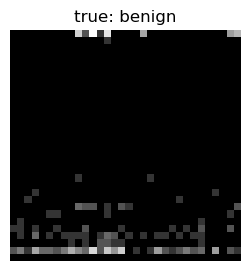

In [18]:
def predict_image(img_path: Path, topk: int = 3):
    # load image and apply eval transform
    img = Image.open(img_path).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    idx = np.argsort(-probs)[:topk]
    results = [(train_ds.classes[i], float(probs[i])) for i in idx]
    return results

# pick one test image automatically
sample_img = next(test_dir.rglob("*.png"))
print("sample image:", sample_img)
print("true class folder:", sample_img.parent.name)

preds = predict_image(sample_img, topk=5)
print("top predictions:")
for cls, p in preds:
    print(f" - {cls}: {p:.4f}")

# show the raw image (before transforms)
plt.figure(figsize=(3, 3))
plt.imshow(Image.open(sample_img), cmap="gray")
plt.title(f"true: {sample_img.parent.name}")
plt.axis("off")
plt.show()


## Save Full Model


In [19]:
# this saves the whole model object (less portable across code changes, but easy)
FULL_MODEL_PATH = SAVE_DIR / "full_model.pt"
torch.save(model, FULL_MODEL_PATH)
print("saved full model to:", FULL_MODEL_PATH)


saved full model to: E:\Project\flow2img\runs\resnet18_multiclass\full_model.pt
